### VAE

### Summary:

A VAE uses two neural networks,

* Encoder ($q_{\phi}(z|x)$): Encodes X into Z. To get Z, we do the following
    * Encoder outputs $\mu$ and log-variance (instead of $\sigma$).
    * Sample $z \sim Normal(\mu, \sigma^2)$ using reparameterization trick.
    
* Decoder ($p_{\theta}(x|z)$): Decode from Z to X.

To train a VAE, we maximize the Evidence Lower Bound (ELBO):

$$ELBO (x) = \mathbb{E}_{q_{\phi}(z|x)}\log(p_{\theta}(x|z)) - \text{KL}[q_{\phi}(z|x) || p(z)]$$

### Import Modules

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

### Prepare Dataloader

In [166]:
batch_size = 128

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['kmnist'] = torchvision.datasets.KMNIST(root='../data', train=True, download=False, transform=transform)
train_set['kmnist_d'] = torchvision.datasets.KMNIST(root='../data', train=True, download=False, transform=transform)
test_set['kmnist'] = torchvision.datasets.KMNIST(root='../data', train=False, download=False, transform=transform)
test_set['kmnist_d'] = torchvision.datasets.KMNIST(root='../data', train=False, download=False, transform=transform)
train_loader['kmnist'] = torch.utils.data.DataLoader(train_set['kmnist'], batch_size=batch_size, shuffle=False, num_workers=0)
train_loader['kmnist_d'] = torch.utils.data.DataLoader(train_set['kmnist_d'], batch_size=batch_size, shuffle=False, num_workers=0)
test_loader['kmnist'] = torch.utils.data.DataLoader(test_set['kmnist'], batch_size=batch_size, shuffle=False, num_workers=0)
test_loader['kmnist_d'] = torch.utils.data.DataLoader(test_set['kmnist_d'], batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cpu'

### Randomly change some pixels to black

In [167]:
def add_black(size,dataset):
    for i in range(dataset.data.shape[0]):
        horizon_point = np.random.randint(0,28-size)
        dataset.data[i, horizon_point:horizon_point+size, horizon_point:horizon_point+size] = 0
    return dataset

In [168]:
train_set['kmnist_d'] = add_black(size=15, dataset=train_set['kmnist_d'])
test_set['kmnist_d'] = add_black(size=15, dataset=test_set['kmnist_d'])

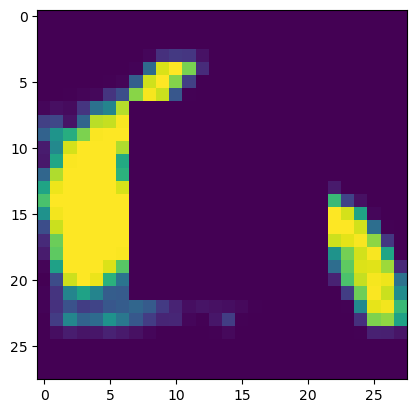

In [169]:
plt.imshow(test_set['kmnist_d'].data[21])

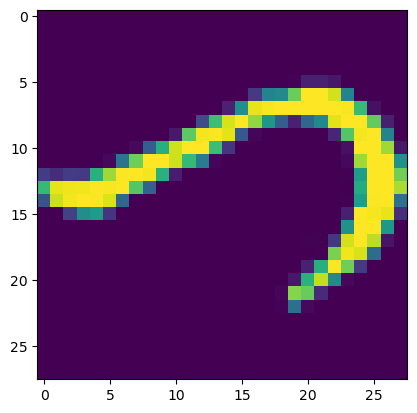

In [170]:
plt.imshow(train_set['kmnist'].data[21])

### This is our VAE model

In [171]:
class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        """Encoder forward pass.
        
        Args:
            x: Input image
            
        Returns:
            mu: self.fc21(h1)
            logvar: self.fc22(h1)
        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev.
            
        Args: 
            mu: mean
            logvar: log of variance
        
        Return:
            z: sample from Normal(mu, var).
            
            Epsilon is sampled from standard normal distribution. 
            \epsilon \sim Normal(0, 1)
        """
        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        """Decoder forward pass.
        
        Args:
            z: Batch of latent representations.
        
        Returns: 
            x_recon: Image probabilities.
        """
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """Implements forward pass of VAE.
        
        Args:
            x: Batch of input images.
        
        Returns:
            x_recon: Batch of reconstructed images.
            mu: Batch of mean vectors
            logvar: Batch of log-variance vectors
        """
        
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.
    
    Args: 
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z
        
        p(z) here is the standard normal distribution with mean 0 and identity covariance.
    """
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [172]:
def train(model, device, train_loader, train_loader_undam, optimizer, epoch):
    train_loss = 0
    model.train()
    for ((x, target), (x_undam, target_undam)) in zip(train_loader, train_loader_undam):
        
        x = x.view(x.size(0),-1)
        x = x.to(device)
        x_undam = x_undam.view(x_undam.size(0),-1)
        x_undam = x_undam.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(x)
        loss = loss_function(output, x_undam, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    print('Epoch ({}) Train Loss: {:.4f}'.format(epoch, train_loss))
    
    return train_loss

def test(model, device, test_loader, test_loader_undam, optimizer, epoch):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for ((x, target), (x_undam, target_undam)) in zip(test_loader, test_loader_undam):
            
            x = x.view(x.size(0),-1)
            x = x.to(device)
            x_undam = x_undam.view(x_undam.size(0),-1)
            x_undam = x_undam.to(device)
            
            output, mu, logvar = model(x)
            loss = loss_function(output, x_undam, mu, logvar)
            test_loss += loss.item() # sum up batch loss
            
    test_loss = test_loss/len(test_loader)
    print('Test({}): Loss: {:.4f}'.format(epoch, test_loss))
    
    return test_loss

In [173]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [174]:
seed = 1
data_name = 'kmnist'
optimizer_name = 'Adam'

num_epochs = 20
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

#device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [176]:
vae = VAE(n_in, n_hid, z_dim)
train_vae_error = []
test_vae_error = []
# train(model, device, train_loader, train_loader_undam, optimizer, epoch):
optimizer = make_optimizer(optimizer_name, vae, lr=lr)
device = None
for epoch in range(1, num_epochs + 1):
    train_vae_error.append(train(vae, device, train_loader['kmnist_d'], train_loader['kmnist'], optimizer, epoch))
    test_vae_error.append(test(vae, device, test_loader['kmnist_d'], test_loader['kmnist'], optimizer, epoch))

Epoch (1) Train Loss: 37261.9791
Test(1): Loss: 33596.9465
Epoch (2) Train Loss: 31805.1964
Test(2): Loss: 31927.1837
Epoch (3) Train Loss: 30615.0414
Test(3): Loss: 31342.4008
Epoch (4) Train Loss: 30040.1020
Test(4): Loss: 30988.2335
Epoch (5) Train Loss: 29660.3870
Test(5): Loss: 30795.6888
Epoch (6) Train Loss: 29389.1475
Test(6): Loss: 30649.5308
Epoch (7) Train Loss: 29185.4815
Test(7): Loss: 30555.5740
Epoch (8) Train Loss: 29020.3253
Test(8): Loss: 30531.2621
Epoch (9) Train Loss: 28894.1324
Test(9): Loss: 30481.1986
Epoch (10) Train Loss: 28790.5414
Test(10): Loss: 30415.6048
Epoch (11) Train Loss: 28680.8345
Test(11): Loss: 30357.6263
Epoch (12) Train Loss: 28606.1668
Test(12): Loss: 30414.3575
Epoch (13) Train Loss: 28519.8634
Test(13): Loss: 30343.4393
Epoch (14) Train Loss: 28459.3652
Test(14): Loss: 30324.1167
Epoch (15) Train Loss: 28391.4871
Test(15): Loss: 30320.8385
Epoch (16) Train Loss: 28333.8711
Test(16): Loss: 30291.4786
Epoch (17) Train Loss: 28280.5477
Test(17)

### This is our C-VAE Model

We will add the label in as a conditional variable c. 

In [221]:
class C_VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(C_VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim+10, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)
        
    def one_hot(self, label):
        one_hot = F.one_hot(label)
        return one_hot.to(torch.float32)
    
    def encode(self, x, label):
        
        """Encoder forward pass.
        
        Args:
            x: Input image
            
        Returns:
            mu: self.fc21(h1)
            logvar: self.fc22(h1)
        """
        
        label = self.one_hot(label)
        concat = torch.cat((x, label), 1)
        h1 = F.relu(self.fc1(concat))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev.
            
        Args: 
            mu: mean
            logvar: log of variance
        
        Return:
            z: sample from Normal(mu, var).
            
            Epsilon is sampled from standard normal distribution. 
            \epsilon \sim Normal(0, 1)
        """
        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z, label):
        """Decoder forward pass.
        
        Args:
            z: Batch of latent representations.
        
        Returns: 
            x_recon: Image probabilities.
        """
        label = self.one_hot(label)
        concat = torch.cat((z, label), 1)
        h3 = F.relu(self.fc3(concat))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, label):
        """Implements forward pass of VAE.
        
        Args:
            x: Batch of input images.
        
        Returns:
            x_recon: Batch of reconstructed images.
            mu: Batch of mean vectors
            logvar: Batch of log-variance vectors
        """
        
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, label), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.
    
    Args: 
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z
        
        p(z) here is the standard normal distribution with mean 0 and identity covariance.
    """
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [222]:
def train(model, device, train_loader, train_loader_undam, optimizer, epoch):
    train_loss = 0
    model.train()
    for ((x, target), (x_undam, target_undam)) in zip(train_loader, train_loader_undam):
        
        x = x.view(x.size(0),-1)
        x = x.to(device)
        x_undam = x_undam.view(x_undam.size(0),-1)
        x_undam = x_undam.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(x, target)
        
        label_oh = model.one_hot(target_undam)
        concat = torch.cat((x_undam, label_oh), 1)
        
        loss = loss_function(output, concat, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    print('Epoch ({}) Train Loss: {:.4f}'.format(epoch, train_loss))
    
    return train_loss

def test(model, device, test_loader, test_loader_undam, optimizer, epoch):
    test_loss = 0
    model.eval()
    
    with torch.no_grad():
        for ((x, target), (x_undam, target_undam)) in zip(test_loader, test_loader_undam):
            
            x = x.view(x.size(0),-1)
            x = x.to(device)
            x_undam = x_undam.view(x_undam.size(0), -1)
            x_undam = x_undam.to(device)
            
            output, mu, logvar = model(x, target)
            
            label_oh = model.one_hot(target_undam)
            concat = torch.cat((x_undam, label_oh), 1)
            
            loss = loss_function(output, concat, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = test_loss / len(test_loader)
    print('Test({}): Loss: {:.4f}'.format(epoch, test_loss))
    return test_loss

In [223]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [224]:
seed = 1

optimizer_name = 'Adam'

num_epochs = 20
lr = 0.001
n_in = 28*28+10
n_hid = 400
z_dim = 20

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [230]:
c_vae = C_VAE(n_in, n_hid, z_dim)

optimizer = make_optimizer(optimizer_name, c_vae, lr=lr)

train_cvae_error = []
test_cvae_error = []
for epoch in range(1, num_epochs + 1):
    train_cvae_error.append(train(c_vae, device, train_loader['kmnist_d'], train_loader['kmnist'], optimizer, epoch))
    test_cvae_error.append(test(c_vae, device, test_loader['kmnist_d'], test_loader['kmnist'], optimizer, epoch))

Epoch (1) Train Loss: 37054.8865
Test(1): Loss: 33219.2510
Epoch (2) Train Loss: 31336.5805
Test(2): Loss: 31476.3349
Epoch (3) Train Loss: 30110.1460
Test(3): Loss: 30863.2916
Epoch (4) Train Loss: 29437.5601
Test(4): Loss: 30397.2623
Epoch (5) Train Loss: 29003.5647
Test(5): Loss: 30182.5157
Epoch (6) Train Loss: 28691.1314
Test(6): Loss: 30033.9542
Epoch (7) Train Loss: 28466.8620
Test(7): Loss: 29857.2746
Epoch (8) Train Loss: 28271.3593
Test(8): Loss: 29778.5983
Epoch (9) Train Loss: 28115.0293
Test(9): Loss: 29703.4948
Epoch (10) Train Loss: 27983.1685
Test(10): Loss: 29648.3851
Epoch (11) Train Loss: 27872.4011
Test(11): Loss: 29628.6470
Epoch (12) Train Loss: 27772.2421
Test(12): Loss: 29586.7785
Epoch (13) Train Loss: 27690.8894
Test(13): Loss: 29567.2200
Epoch (14) Train Loss: 27618.5066
Test(14): Loss: 29559.7044
Epoch (15) Train Loss: 27544.1196
Test(15): Loss: 29519.9451
Epoch (16) Train Loss: 27482.9349
Test(16): Loss: 29460.6990
Epoch (17) Train Loss: 27415.6904
Test(17)

### Visualization

In [261]:
def show_methodcompare(img1, img2, img3, img4, method=None):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    npimg3 = img3.cpu().numpy()
    npimg4 = img4.cpu().numpy()
    fig, axes = plt.subplots(1,4, figsize=(12,5))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    axes[2].imshow(np.transpose(npimg3, (1,2,0)), interpolation='nearest')
    axes[3].imshow(np.transpose(npimg4, (1,2,0)), interpolation='nearest')
    axes[0].set_title('Damaged Images', fontsize=10)
    axes[1].set_title('Restored Images from VAE', fontsize=10)
    axes[2].set_title('Restored Images from C-VAE', fontsize=10)
    axes[3].set_title('Original Images', fontsize=10)

In [251]:
### data for damaged pictures, data_undamage for undamaged pictures
data,label = next(iter(test_loader['kmnist_d']))
data = data[:128]
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
data_undamage, _ = next(iter(test_loader['kmnist']))
data_undamage = data_undamage[:128]
data_undamage = data_undamage.view(data.size(0),-1).to(device)

In [252]:
output_vae, _, _ = vae(data)
output_vae = output_vae.detach()
output_cvae, _, _ = c_vae(data,label)
output_cvae = output_cvae.detach()

In [253]:
output_cvae.shape

torch.Size([128, 794])

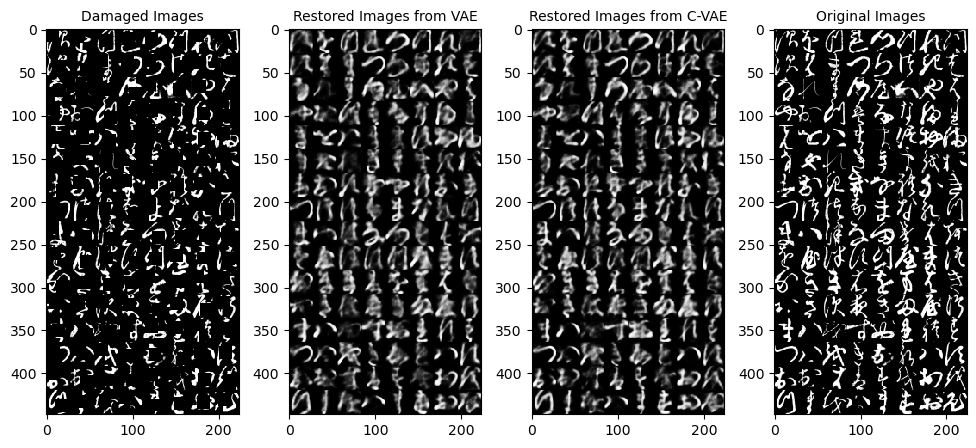

In [262]:
show_methodcompare(make_grid(data.reshape(data_size), padding=0), make_grid(output_vae.reshape(data_size), padding=0),
                   make_grid(output_cvae[:,0:784].reshape(data_size), padding=0), make_grid(data_undamage.reshape(data_size),padding=0), method='C-VAE')